In [5]:
import torch
import torchaudio
import torchtext
import torchaudio.functional as F
import torchaudio.transforms as T
from audio_augmentations import *

import os, re, random
import numpy as np
import sklearn
import itertools
import time

import pickle
from tqdm.auto import tqdm
from IPython.display import clear_output
import IPython.display as ipd
import gc
import matplotlib.pyplot as plt
import wandb

print(torch.__version__)
print(torchaudio.__version__)

import sys
sys.path.append('/Users/litvan007/NN_commands_recognition/')

2.0.0
2.0.1


In [6]:
random.seed(123456)
np.random.seed(123456)
torch.manual_seed(123456)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cpu')

In [7]:
def plot_waveform(waveform, mfcc, sample_rate=16000, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_frames = waveform.size
    time_axis = torch.arange(0, num_frames) / sample_rate

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
    ax1.plot(time_axis, waveform, linewidth=1)
    ax1.set_xlabel('Time')
    ax1.set_title('Signal')

    ax2.specgram(waveform, Fs=sample_rate)
    ax2.set_xlabel('Time')
    ax2.set_title('Spectrogram')

    ax3.imshow(mfcc, interpolation='nearest', origin='lower', aspect='auto')
    ax3.set_xlabel('Frame')
    ax3.set_title('MFCC')

    plt.suptitle(title)
    plt.show()
    
    ax1.grid(True)
    if xlim:
        ax1.set_xlim(xlim)
        
    fig.suptitle(title)
    plt.show()

# Getting data

In [8]:
data_path = '../data 2'
data_list = []
with open(os.path.join(data_path, 'data_base_audio.pickle'), 'rb') as fh:
    data_list = pickle.load(fh)
len(data_list)

27456

## revising mistakes

In [9]:
# from transliterate import translit

# for i in tqdm(range(len(data_list))):
#     path = os.path.join(data_path, data_list[i]['name'])
#     data_list[i]['name'] = translit(data_list[i]['name'], reversed=True)
#     data_list[i]['label'] = translit(data_list[i]['label'], reversed=True)
#     os.rename(path, os.path.join(data_path, data_list[i]['name']))

# with open(f'../data/data_base_audio.pickle', 'wb') as f:
#     pickle.dump(data_list, f)
# data_list

In [10]:
# for sound in tqdm(data_list):
#     path = os.path.join(data_path, sound['name'])
#     try:
#         audio = torchaudio.load(path)
#         if audio[0].size(1) == 0:
#             print(audio[0].size(1))
#             data_list.remove(sound)
#             os.remove(path)
#             print(f'Removed {sound["name"]}')
#     except RuntimeError:
#         print(sound)
#         data_list.remove(sound)

# with open(f'../data/data_base_audio.pickle', 'wb') as f:
#     pickle.dump(data_list, f)
    
# print( len(data_list) )

# import glob
# from pathlib import Path
# (len(list(Path('../data/').glob('**/*')))) ## 2

In [11]:
data_list

[{'name': 'user_471339835/Vpravo_8_1.wav', 'label': 'Vpravo'},
 {'name': 'user_471339835/Vpravo_8_1_new_1.wav', 'label': 'Vpravo'},
 {'name': 'user_471339835/Vpravo_8_1_new_2.wav', 'label': 'Vpravo'},
 {'name': 'user_471339835/Vpravo_8_1_new_3.wav', 'label': 'Vpravo'},
 {'name': 'user_471339835/Vpravo_8_1_new_4.wav', 'label': 'Vpravo'},
 {'name': 'user_471339835/Vpravo_8_1_new_5.wav', 'label': 'Vpravo'},
 {'name': 'user_471339835/Vpravo_8_1_new_6.wav', 'label': 'Vpravo'},
 {'name': 'user_471339835/Vpravo_8_1_new_7.wav', 'label': 'Vpravo'},
 {'name': 'user_471339835/Vpravo_8_1_new_8.wav', 'label': 'Vpravo'},
 {'name': 'user_471339835/Vpravo_8_1_new_9.wav', 'label': 'Vpravo'},
 {'name': 'user_471339835/Vpravo_8_1_new_10.wav', 'label': 'Vpravo'},
 {'name': 'user_471339835/Vpravo_8_1_new_11.wav', 'label': 'Vpravo'},
 {'name': 'user_471339835/Vpravo_8_1_new_12.wav', 'label': 'Vpravo'},
 {'name': 'user_471339835/Vpravo_8_1_new_13.wav', 'label': 'Vpravo'},
 {'name': 'user_471339835/Vpravo_8_1

In [12]:
all_labels = set()
for example in data_list:
    all_labels.add(example['label'])

all_labels

{'Domoj',
 "Dvigat'sja",
 'Najti',
 "Opustit'",
 "Ostanovit'sja",
 "Otkryt'",
 "Podnjat'",
 "Smenit'",
 "Sohranit'",
 'Start',
 'Stop',
 'Vlevo',
 'Vniz',
 'Vpravo',
 'Vverh',
 "Zagruzit'",
 "Zahvatit'",
 "Zakryt'"}

In [13]:
token_to_idx = {x: idx for idx, x in enumerate(all_labels)}

token_to_idx

{"Dvigat'sja": 0,
 "Zakryt'": 1,
 "Zagruzit'": 2,
 "Zahvatit'": 3,
 "Sohranit'": 4,
 'Vlevo': 5,
 'Vniz': 6,
 "Podnjat'": 7,
 "Opustit'": 8,
 'Domoj': 9,
 "Smenit'": 10,
 'Vverh': 11,
 "Ostanovit'sja": 12,
 'Vpravo': 13,
 'Najti': 14,
 'Stop': 15,
 "Otkryt'": 16,
 'Start': 17}

split 80:10:10

In [14]:
lengths_subsets = {'train': int(0.8 * len(data_list)), 'valid': round(0.1 * len(data_list)), 'test': round(0.1 * len(data_list))}
train_vaild_subset, test_subset = torch.utils.data.random_split(data_list, 
                                                                [lengths_subsets['train']+lengths_subsets['valid'], lengths_subsets['test']])
train_subset, valid_subset = torch.utils.data.random_split(train_vaild_subset, 
                                                                [lengths_subsets['train'], lengths_subsets['valid']])
lengths_subsets

{'train': 21964, 'valid': 2746, 'test': 2746}

# Creating dataset

In [15]:
class Sound_dataset_commands(torch.utils.data.Dataset):
    def __init__(self, rootdir, subset, transform=None):
        self.transform = transform
        self.rootdir = rootdir
        self.subset = subset
        self.n_subset = len(self.subset)
        self.token_to_idx = {x: idx for idx, x in enumerate(all_labels)}
        self.idx_to_token = {idx: x for idx, x in enumerate(all_labels)}

    def __getitem__(self, index):
        name, label = self.subset[index].values()
        signal, sample_rate = torchaudio.load(os.path.join(self.rootdir, name))
        signal = signal[0]

        if self.transform:
            print(name, signal)
            feature_map = self.transform(signal)
            # signal = self.transform.transforms[0](signal)
        idx_label = self.token_to_idx[label]

        return feature_map, idx_label, signal, name, label

    def __len__(self):
        return len(self.subset)

In [16]:
# 30мс 10мс шаг
n_fft = 480
win_length = None
hop_length = 160
n_mels = 92
n_mfcc = 28
mfcc_transform = T.MFCC(
    sample_rate=8000,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mfcc * 2,
        "hop_length": hop_length,
        "f_min": 20,
        "f_max": 4000
    },
)

transforms = [
    # RandomApply([Noise(min_snr=0.1, max_snr=0.3)], p=0.5),
    mfcc_transform
]
transform = Compose(transforms=transforms)
data_set = {
            'train': Sound_dataset_commands(rootdir=data_path, subset=train_subset, transform=transform),
            'valid': Sound_dataset_commands(rootdir=data_path, subset=valid_subset, transform=transform),
            'test': Sound_dataset_commands(rootdir=data_path, subset=test_subset, transform=transform)
           }
c = itertools.cycle(data_set['train'])

In [17]:
def plot_waveform_new(waveform, mfcc, sample_rate=16000, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_frames = waveform.size
    time_axis = torch.arange(0, num_frames) / sample_rate

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    ax1.plot(time_axis, waveform, linewidth=1)
    ax1.set_xlabel('Time')
    ax1.set_title('Signal')

    im1 = ax2.imshow(mfcc, interpolation='nearest', origin='lower', aspect='auto')
    fig.colorbar (im1, ax=ax2)
    ax2.set_xlabel('Frame')
    ax2.set_title('MFCC')

    plt.suptitle(title)
    plt.show()
    
    ax1.grid(True)
    if xlim:
        ax1.set_xlim(xlim)
        
    fig.suptitle(title)
    plt.show()

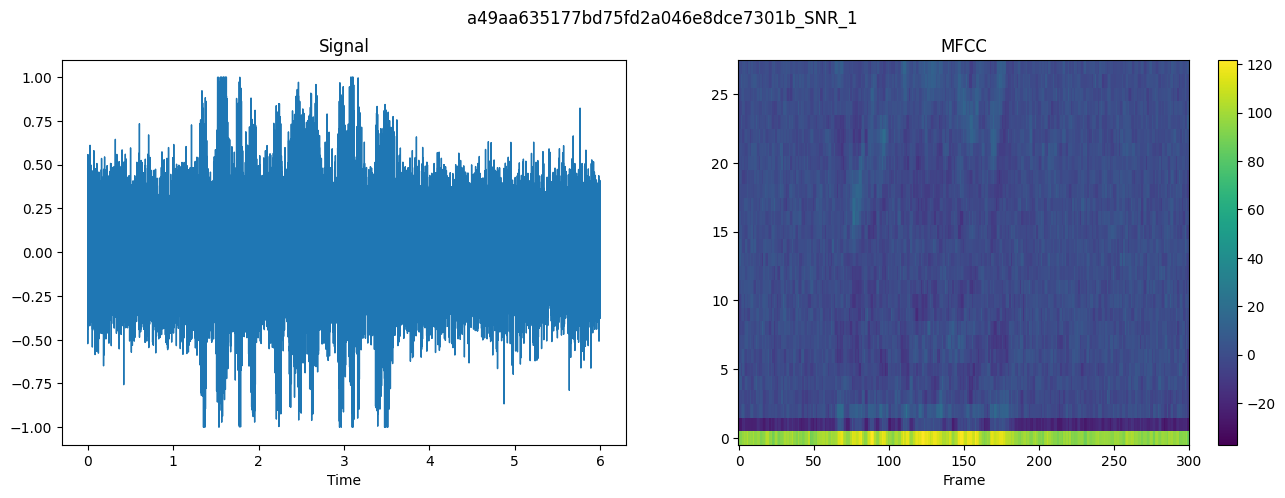

In [19]:
signal_temp = torchaudio.load('/Users/litvan007/NN_sound_data_base/data_2/a49aa635177bd75fd2a046e8dce7301b_SNR_1.wav')[0][0]
mfcc_temp = mfcc_transform(signal_temp)
plot_waveform_new(signal_temp, mfcc_temp, sample_rate=8000, title='a49aa635177bd75fd2a046e8dce7301b_SNR_1')

In [20]:
mfcc_temp.shape

torch.Size([28, 301])

user_347619254/Zahvatit'_3_3_new_5.wav tensor([ 0.0375,  0.0034, -0.0083,  ..., -0.0228, -0.0053,  0.0169])


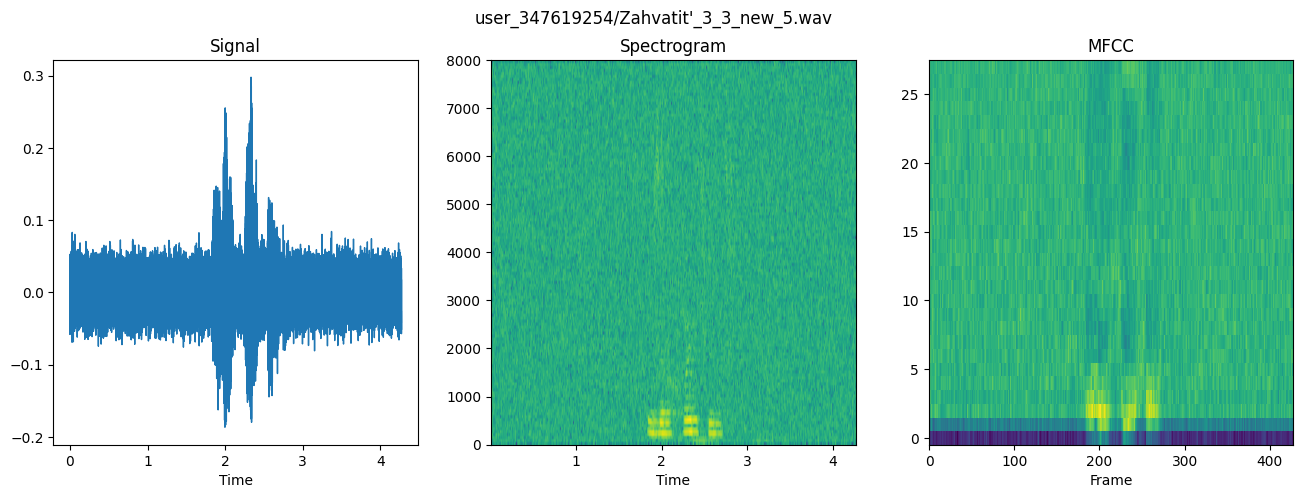

In [ ]:
mfcc, label, signal, xname, label = next(c)
plot_waveform(signal, mfcc, sample_rate=16000, title=f'{xname}')
ipd.Audio(signal, rate=16000)

## Wandb data input

In [ ]:
def create_plots(signal, feature_map, name_fig, sample_rate=16000, 
                            signal_plot_dir='signal_plots', 
                            spec_plot_dir='spec_plots', 
                            mfcc_plot_dir='mfcc_plots',
                            notebook_path='/kaggle/working/Voice-commands-recognition/notebooks'):
    
    signal = signal.numpy()

    num_frames = signal.size
    time_axis = torch.arange(0, num_frames) / sample_rate

    plt.plot(time_axis, signal, linewidth=1)
    plt.xlabel('Time')
    plt.title('Signal')
    plt.grid()
    plt.savefig(os.path.join(notebook_path, signal_plot_dir, name_fig))
    plt.clf()

    plt.specgram(signal, Fs=sample_rate)
    plt.xlabel('Time')
    plt.title('Spectrogram')
    plt.savefig(os.path.join(notebook_path, spec_plot_dir, name_fig))
    plt.clf()

    plt.imshow(feature_map, interpolation='nearest', origin='lower', aspect='auto')
    plt.xlabel('Frame')
    plt.title('MFCC')
    plt.savefig(os.path.join(notebook_path, mfcc_plot_dir, name_fig))
    plt.clf()
    

In [ ]:
# columns = ["name", "song_file", "signal_plot", "spec_plot", "mfcc_plot", "Label", "Set"]
# table = wandb.Table(columns=columns)

# signal_plot_dir='signal_plots'
# spec_plot_dir='spec_plots'
# mfcc_plot_dir='mfcc_plots'

# # for set_name, curr_data_set in data_set.items():
# #     print(set_name)
# for feature_map, idx_label, signal, name, label in tqdm(data_set['valid']):
#     name_fig = f'{name.replace("/", "_").split(".")[0]}.png'
#     create_plots(signal, feature_map, name_fig)    
#     temp = [name, 
#             wandb.Audio(signal, sample_rate=16000), 
#             wandb.Image(os.path.join( signal_plot_dir, name_fig )),
#             wandb.Image(os.path.join( spec_plot_dir, name_fig )),
#             wandb.Image(os.path.join( mfcc_plot_dir, name_fig )),
#             label, 'valid']
#     table.add_row(*temp)
#     # os.remove(os.path.join( signal_plot_dir, name_fig ))
#     # os.remove(os.path.join( spec_plot_dir, name_fig ))
#     # os.remove(os.path.join( mfcc_plot_dir, name_fig ))

# wandb.run.log({"songs" : table}) 

In [ ]:
from models.model import Speech_recognition_model
import yaml

# Сделать разные конфиги
params = None
with open("../configs/model_params.yaml", "r") as stream:
    try:
        params = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [ ]:
params

{'Architecture': {'CNN_params': {'in_channels': 1,
   'out_channels': 32,
   'kernel_size': 3,
   'stride': 2,
   'padding': 1},
  'ResCNN_params': {'in_channels': 32,
   'out_channels': 32,
   'kernel_size': 3,
   'stride': 1,
   'dropout': 0.1,
   'n_feats': 23,
   'padding': 1,
   'n_cnn_layers': 3},
  'Fully_connected_params': {'in_features': 736, 'out_features': 512},
  'RNN_params': {'input_size': 512,
   'hidden_size': 512,
   'num_layers': 5,
   'bidirectional': True,
   'dropout': 0.1,
   'rnn_type': 'lstm'},
  'Attention_params': {'feature_dim': 512, 'step_dim': 10},
  'Classifier_params': {'in_features': 512,
   'out_features': 256,
   'dropout': 0.1,
   'n_class': 18}},
 'Settings': {'Optimizer_Scheduler': {'lr_rate': '5e-4',
   'weight_decay': 0.0005,
   'amsgrad': True,
   'max_lr': 0.05,
   'div_factor': 250,
   'max_norm': 1},
  'Other': {'epochs': 10, 'batch_size': 128}}}

## Data Loader

In [ ]:
def collate_fn(batch):
    X = torch.nn.utils.rnn.pad_sequence([sample[0].transpose(0, 1) for sample in batch], batch_first=True, padding_value=0).unsqueeze(1)
    y = torch.tensor([sample[1] for sample in batch])

    signal = [sample[2] for sample in batch]
    name = [sample[3] for sample in batch]
    label = [sample[4] for sample in batch]

    return X, y, signal, name, label

epochs, batch_size = params['Settings']['Other'].values()
loaders = {
            'train': torch.utils.data.DataLoader(data_set['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_fn),
            'valid': torch.utils.data.DataLoader(data_set['valid'], batch_size=batch_size, shuffle=True, collate_fn=collate_fn),
            'test': torch.utils.data.DataLoader(data_set['test'], batch_size=1, shuffle=False, collate_fn=collate_fn)
          }

# Обучение и тестирование

## Wandb init

In [ ]:
!wandb login --relogin 
wandb.init(project="Commands Recognition", name="pre_training_1", config=params)
columns = ["name", "song_file", "signal_plot", "spec_plot", "mfcc_plot", "pred_label", "true_label"]
valid_table = wandb.Table(columns=columns)

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: litvan. Use `wandb login --relogin` to force relogin


In [ ]:
lr_rate, weight_decay, amsgrad, max_lr, div_factor, max_norm = params['Settings']['Optimizer_Scheduler'].values()
model = Speech_recognition_model(**(params['Architecture']))
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(),
                              lr=max_lr/div_factor,
                              weight_decay=weight_decay,
                              amsgrad=amsgrad)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr,
                            steps_per_epoch=len(loaders['train']),
                            epochs=epochs, div_factor=div_factor)
model

Speech_recognition_model(
  (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (rescnn_layers): Sequential(
    (0): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
      (layer_norm2): CNNLayerNorm(
        (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((32,

In [ ]:
def get_accuracy(y_pred, y_test):
    correct_results_sum = (y_pred == y_test).sum().float()
    acc = correct_results_sum/(y_test.size(0))
    
    return acc

In [ ]:
signal_plot_dir = 'signal_plots'
spec_plot_dir = 'spec_plots'
mfcc_plot_dir = 'mfcc_plots'
notebook_path = '/kaggle/working/Voice-commands-recognition/notebooks'

def run_one_epoch(epoch, cross_valid=False, print_freq=1):
    start = time.time()
    total_loss = 0
    total_accuracy = 0

    data_loader = loaders['train'] if not cross_valid else loaders['valid']

    for i, (data) in enumerate(tqdm(data_loader)):
        feature_map, idx_label, signal, name, label = data
        input_data = feature_map.to(device)
        target_labels = idx_label.to(device)

        output_logits = model(input_data)
        loss = criterion(output_logits, target_labels)
        if not cross_valid:
            optimizer.zero_grad()
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                        max_norm)
            optimizer.step()

        total_loss += loss.item()
        pred_labels = torch.round(torch.sigmoid(output_logits)).type(torch.int8).argmax(1)
        accuracy = get_accuracy(pred_labels, target_labels)
        total_accuracy += accuracy
        optim_state = optimizer.state_dict()
        curr_lr = optim_state['param_groups'][0]['lr']
        
        if i % print_freq == 0:
                print('Epoch {0} | Iter {1} | Average Loss {2:.3f} | '
                      'Current Loss {3:.6f} | Current accuracy {4:.6f} | Current lr {5:.5f} | {6:.1f} ms/batch'.format(
                          epoch + 1, i + 1, total_loss / (i + 1),
                          loss.item(), accuracy, curr_lr, 1000 * (time.time() - start) / (i + 1)),
                      flush=True)

        if cross_valid:
            name_fig = f'{name[0].replace("/", "_").split(".")[0]}.png'
            create_plots(signal[0], feature_map[0][0], name_fig)    
            temp = [name[0], 
                wandb.Audio(signal[0], sample_rate=16000), 
                wandb.Image(os.path.join( notebook_path, signal_plot_dir, name_fig )),
                wandb.Image(os.path.join( notebook_path, spec_plot_dir, name_fig )),
                wandb.Image(os.path.join( notebook_path, mfcc_plot_dir, name_fig )),
                pred_labels[0],
                target_labels[0]]
            valid_table.add_row(*temp)
        
    return total_loss / (i + 1), total_accuracy / (i + 1)

## Мысли насчет Wandb Sweep

In [ ]:
!wandb login --relogin a4fc0db907801a21173615cb84708e1774b986a4

In [ ]:
from models.model import Speech_recognition_model
import yaml

# Сделать разные конфиги
params = None
with open("../configs/model_params.yaml", "r") as stream:
    try:
        params = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [ ]:
params

{'Architecture': {'CNN_params': {'in_channels': 1,
   'out_channels': 32,
   'kernel_size': 3,
   'stride': 2,
   'padding': 1},
  'ResCNN_params': {'in_channels': 32,
   'out_channels': 32,
   'kernel_size': 3,
   'stride': 1,
   'dropout': 0.1,
   'n_feats': 23,
   'padding': 1,
   'n_cnn_layers': 3},
  'Fully_connected_params': {'in_features': 736, 'out_features': 512},
  'RNN_params': {'input_size': 512,
   'hidden_size': 512,
   'num_layers': 5,
   'bidirectional': True,
   'dropout': 0.1,
   'rnn_type': 'lstm'},
  'Attention_params': {'feature_dim': 512, 'step_dim': 10},
  'Classifier_params': {'in_features': 512,
   'out_features': 256,
   'dropout': 0.1,
   'n_class': 18}},
 'Settings': {'Optimizer_Scheduler': {'lr_rate': '5e-4',
   'weight_decay': 0.0005,
   'amsgrad': True,
   'max_lr': 0.05,
   'div_factor': 250,
   'max_norm': 1},
  'Other': {'epochs': 10, 'batch_size': 128}}}

In [ ]:
input_config = {'Architecture': 
                    {'CNN_params': {'in_channels': 1, 'out_channels': 32, 'kernel_size': 3, 'stride': 2, 'padding': 1}, 
                    'ResCNN_params': {'in_channels': 32, 'out_channels': 32, 'kernel_size': 3, 'stride': 1, 
                                     'dropout': 0.1, 'n_feats': 23, 'padding': 1, 'n_cnn_layers': 3}, 

                    'Fully_connected_params': {'in_features': 736, 'out_features': 512}, 
                    'RNN_params': {'input_size': 512, 'hidden_size': 512, 'num_layers': 5, 'bidirectional': True, 
                                            'dropout': 0.1, 'rnn_type': 'lstm'}, 

                    'Attention_params': {'feature_dim': 512, 'step_dim': 10}, 
                    'Classifier_params': {'in_features': 512, 'out_features': 256, 'dropout': 0.1, 'n_class': 18}}, 
                    
                'Settings': 
                    {'Optimizer_Scheduler': 
                        {'lr_rate': '5e-4', 'weight_decay': 0.0005, 'amsgrad': True, 'max_lr': 0.05, 'div_factor': 250, 'max_norm': 1}, 
                    'Other': {'epochs': 10, 'batch_size': 128}}}

In [ ]:
sweep_configuration = {
    'method': 'random',
    'metric': {'goal': 'minimize', 'name': 'valid_loss'},
    'parameters': 
        { "input_features": {"n_mels": {"values": [32, 64, 128]}, "n_mfcc": {"min": 26, "max": 128}},
            "Architecture": {"CNN_out_channels": [32, 64], "CNN_kernel_size": [3, 5],
                             "ResCNN_kernel_size": [3, 5], "ResCNN_dropout": {'min': 0.1, 'max': 0.6}, "ResCNN_n_cnn_layers": {'min': 1, "max": 5},
                             "FC_out_features": {"values": [128, 256, 512, 1024]},
                             "RNN_hidden_size": {"values": [128, 256, 512, 1024]}, "RNN_num_layres": {'min': 1, 'max': 6}, "RNN_bi": {'values': [True, False]}, "RNN_dropout": {'min': 0.1, 'max': 0.5},
                             "Att_step": {'values': [5, 10, 15]},
                             "Classifier_dropout": {'min': 0.1, 'max': 0.5}},
            "Setting": {'Optimizer_Scheduler': 
                        {'weight_decay': {'min': 0.0001, 'max': 0.0007}, 'amsgrad': {'values': [False, True]}, 'max_lr': {'min': 0.01, 'max': 0.1}, 'div_factor': {'min': 100, 'max': 300}, 'max_norm': {'min': 0.5, 'max': 1.1}}, 
                        'Other': {'epochs': 10, 'batch_size': {'values': [64, 128]}}}
        }
}

In [ ]:
wandb.init(project="Commands Recognition", name="Sweeping", config=params)
wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: litvan. Use `wandb login --relogin` to force relogin


{'Architecture': {'CNN_params': {'in_channels': 1, 'out_channels': 32, 'kernel_size': 3, 'stride': 2, 'padding': 1}, 'ResCNN_params': {'in_channels': 32, 'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'dropout': 0.1, 'n_feats': 23, 'padding': 1, 'n_cnn_layers': 3}, 'Fully_connected_params': {'in_features': 736, 'out_features': 512}, 'RNN_params': {'input_size': 512, 'hidden_size': 512, 'num_layers': 5, 'bidirectional': True, 'dropout': 0.1, 'rnn_type': 'lstm'}, 'Attention_params': {'feature_dim': 512, 'step_dim': 10}, 'Classifier_params': {'in_features': 512, 'out_features': 256, 'dropout': 0.1, 'n_class': 18}}, 'Settings': {'Optimizer_Scheduler': {'lr_rate': '5e-4', 'weight_decay': 0.0005, 'amsgrad': True, 'max_lr': 0.05, 'div_factor': 250, 'max_norm': 1}, 'Other': {'epochs': 10, 'batch_size': 128}}}

In [ ]:
torch.cuda.empty_cache()
gc.collect()

def sweep_func():    
    wan

    run = wandb.init(project="Commands Recognition", name="Sweeping", config=params)
    columns = ["name", "song_file", "signal_plot", "spec_plot", "mfcc_plot", "pred_label", "true_label"]
    valid_table = wandb.Table(columns=columns)

    lr_rate, weight_decay, amsgrad, max_lr, div_factor, max_norm = params['Settings']['Optimizer_Scheduler'].values()
    model = Speech_recognition_model(**(params['Architecture'])).to(device)
    criterion = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(),
                                lr=max_lr/div_factor,
                                weight_decay=weight_decay,
                                amsgrad=amsgrad)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr,
                            steps_per_epoch=len(loaders['train']),
                            epochs=epochs, div_factor=div_factor)

    epoch = 0
    checkpoint = False
    visdom = True
    save_folder = '../checkpoints'

    tr_loss = []
    cv_loss = []
    tr_acc = []
    cv_acc = []
    best_val_loss = 0.1

    wandb.watch(model, log_freq=1, log='all')
    for epoch in tqdm(np.arange(epoch, epochs)):
        print("Training...")
        model.train()
        start = time.time()
        tr_avg_loss, tr_avg_acc = run_one_epoch(epoch)
        tr_loss.append(tr_avg_loss)
        tr_acc.append(tr_avg_acc)

        print('-' * 85)
        print('Train Summary | End of Epoch {0} | Time {1:.2f}s | '
                    'Train Loss {2:.3f} | Accuracy {3:.3f}'.format(
                        epoch + 1, time.time() - start, tr_avg_loss, tr_avg_acc))
        print('-' * 85)

        if checkpoint:
            file_path = os.path.join(
            save_folder, 'epoch_{0}_loss_{1:.4f}.pth.tar'.format(epoch + 1, cv_avg_loss))
            torch.save(model.serialize(model, optimizer, scheduler, epoch + 1,
                                            tr_loss=tr_loss,
                                            cv_loss=cv_loss),
                    file_path)
            print('Saving checkpoint model to %s' % file_path)

        print('Cross validation...')
        model.eval()  # Turn off Batchnorm & Dropout
        cv_avg_loss, cv_avg_acc = run_one_epoch(epoch, cross_valid=True)
        cv_loss.append(cv_avg_loss)
        cv_loss.append(cv_avg_acc)

        print('-' * 185)
        print('Valid Summary | End of Epoch {0} | Time {1:.2f}s | '
                'Valid Loss {2:.3f} | Accuracy {3:.3f}'.format(
                    epoch + 1, time.time() - start, cv_avg_loss, cv_avg_acc))
        print('-' * 185)

        # Save the best model
        if cv_avg_loss < best_val_loss:
            best_val_loss = cv_avg_loss
            model_path = 'epoch_{0}_loss_{1:.4f}_best.pth.tar'.format(epoch + 1, cv_avg_loss)
            file_path = os.path.join(save_folder, model_path)
            torch.save(model.serialize(model, optimizer, scheduler, epoch + 1,
                                        tr_loss=tr_loss,
                                        cv_loss=cv_loss),
                    file_path)
            print("Find better validated model, saving to %s" % file_path)
        

        wandb.log({"epoch": epoch, "train_loss": tr_avg_loss})
        wandb.log({"epoch": epoch, "valid_loss": cv_avg_loss})
        wandb.log({"epoch": epoch, "train_accuracy": tr_avg_acc})
        wandb.log({"epoch": epoch, "valid_accuracy": cv_avg_acc})
        wandb.run.log({"valid_inference" : valid_table}) 

    wandb.finish()

In [ ]:
wandb.agent(sweep_configuration, function=sweep_func, count=15)